In [37]:
import random
from joblib import  load
import numpy as np
import numpy.ma as ma  

import pandas as pd

from scipy.stats import mannwhitneyu

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences


# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [38]:
palette_models = {  
    'HydrAMP': '#B80018',       
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
    'AMP-GAN': '#FA9F42',        
}


TEMPS = {
    'HydrAMP': [1, 2, 5],
    'PepCVAE': [1],
    'Basic': [1],
}

In [39]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [40]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_molarweight(x:list):
    h = modlamp.descriptors.GlobalDescriptor(data)
    h.calculate_MW()
    return list(h.descriptor.flatten())

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())

def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)

def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())


In [41]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

# Unconstrained

In [42]:

positives = pd.read_csv('../../data/positives_test.tsv', sep='\t', header=None)[1].tolist()
negatives = pd.read_csv('../../data/negatives_test.tsv', sep='\t', header=None)[1].tolist()

#Load Uniprot
uniprot = list(pd.read_csv('../../data/Uniprot_0_25_train.csv').Sequence)
uniprot = random.sample(uniprot, 50000)


#Get random peptides
random_gen = modlamp.sequences.Random(50000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [43]:
hydra_results = load(f'../../results/unconstrained_HydrAMP.joblib')
pepcvae_results = load(f'../../results/unconstrained_PepCVAE.joblib')
basic_results = load(f'../../results/unconstrained_Basic.joblib')

In [44]:
hydra_positives = select_peptides(hydra_results, 'pos').sequence.tolist()
hydra_negatives = select_peptides(hydra_results, 'neg').sequence.tolist()

pepcvae_positives = select_peptides(pepcvae_results, 'pos').sequence.tolist()
pepcvae_negatives = select_peptides(pepcvae_results, 'neg').sequence.tolist()

basic_positives = select_peptides(basic_results, 'pos').sequence.tolist()
basic_negatives = select_peptides(basic_results, 'neg').sequence.tolist()

In [45]:
# Generated 100K sequences
# Read amp-gan peptides
ampgan_peptides = pd.read_csv('../../data/benchmarks_data/amp-gan/generated_samples_trunc_2022-08-04.csv')
# Get rid of seqs > 25 and get 50K seq to compare with hydramp
ampgan_peptides = ampgan_peptides[ampgan_peptides['sequence'].str.len() < 26].iloc[:50000]
ampgan_positives = ampgan_peptides.sequence.tolist()

In [46]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []


    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [47]:
datasets = [
    'Random',
    'Uniprot',
    'Non-AMP test data',
    'Non-AMP HydrAMP',
    'Non-AMP PepCVAE',
    'Non-AMP Basic',
    'AMP test data',
    'AMP HydrAMP',
    'AMP PepCVAE',
    'AMP Basic',
    'AMP AMP-GAN'
]

peptides = [
    random_peptides,
    uniprot,
    negatives,
    hydra_negatives,
    pepcvae_negatives,
    basic_negatives,
    positives,    
    hydra_positives,
    pepcvae_positives,   
    basic_positives,    
    ampgan_positives

]

In [48]:
physchem = calculate_physchem(peptides, datasets)

In [74]:
physchem_temp = physchem.loc[:, ['pi', 'charge', 'hm', 'aromacity', 'dataset']]
physchem_quantiles = physchem_temp.groupby('dataset').quantile([0.25, 0.5, 0.75])
physchem_quantiles.to_csv('Supp_SourceData_FigureS1_quantiles.csv')

In [50]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [51]:
datasets = [
    ['Random','Uniprot'],
    ['Non-AMP test data', 'AMP test data'],
    ['Non-AMP HydrAMP', 'AMP HydrAMP'],
    ['Non-AMP PepCVAE', 'AMP PepCVAE'],
    ['Non-AMP Basic', 'AMP Basic'],
    [None, 'AMP AMP-GAN']
]

In [52]:
def choose_symbol(test_results):
    if test_results > 0.05:
        symbol = 'ns'
    if test_results <= 0.05:
        symbol = '*'
    if test_results <= 0.01:
        symbol = '**'
    if test_results <= 0.001:
        symbol = '***'
    return symbol
    

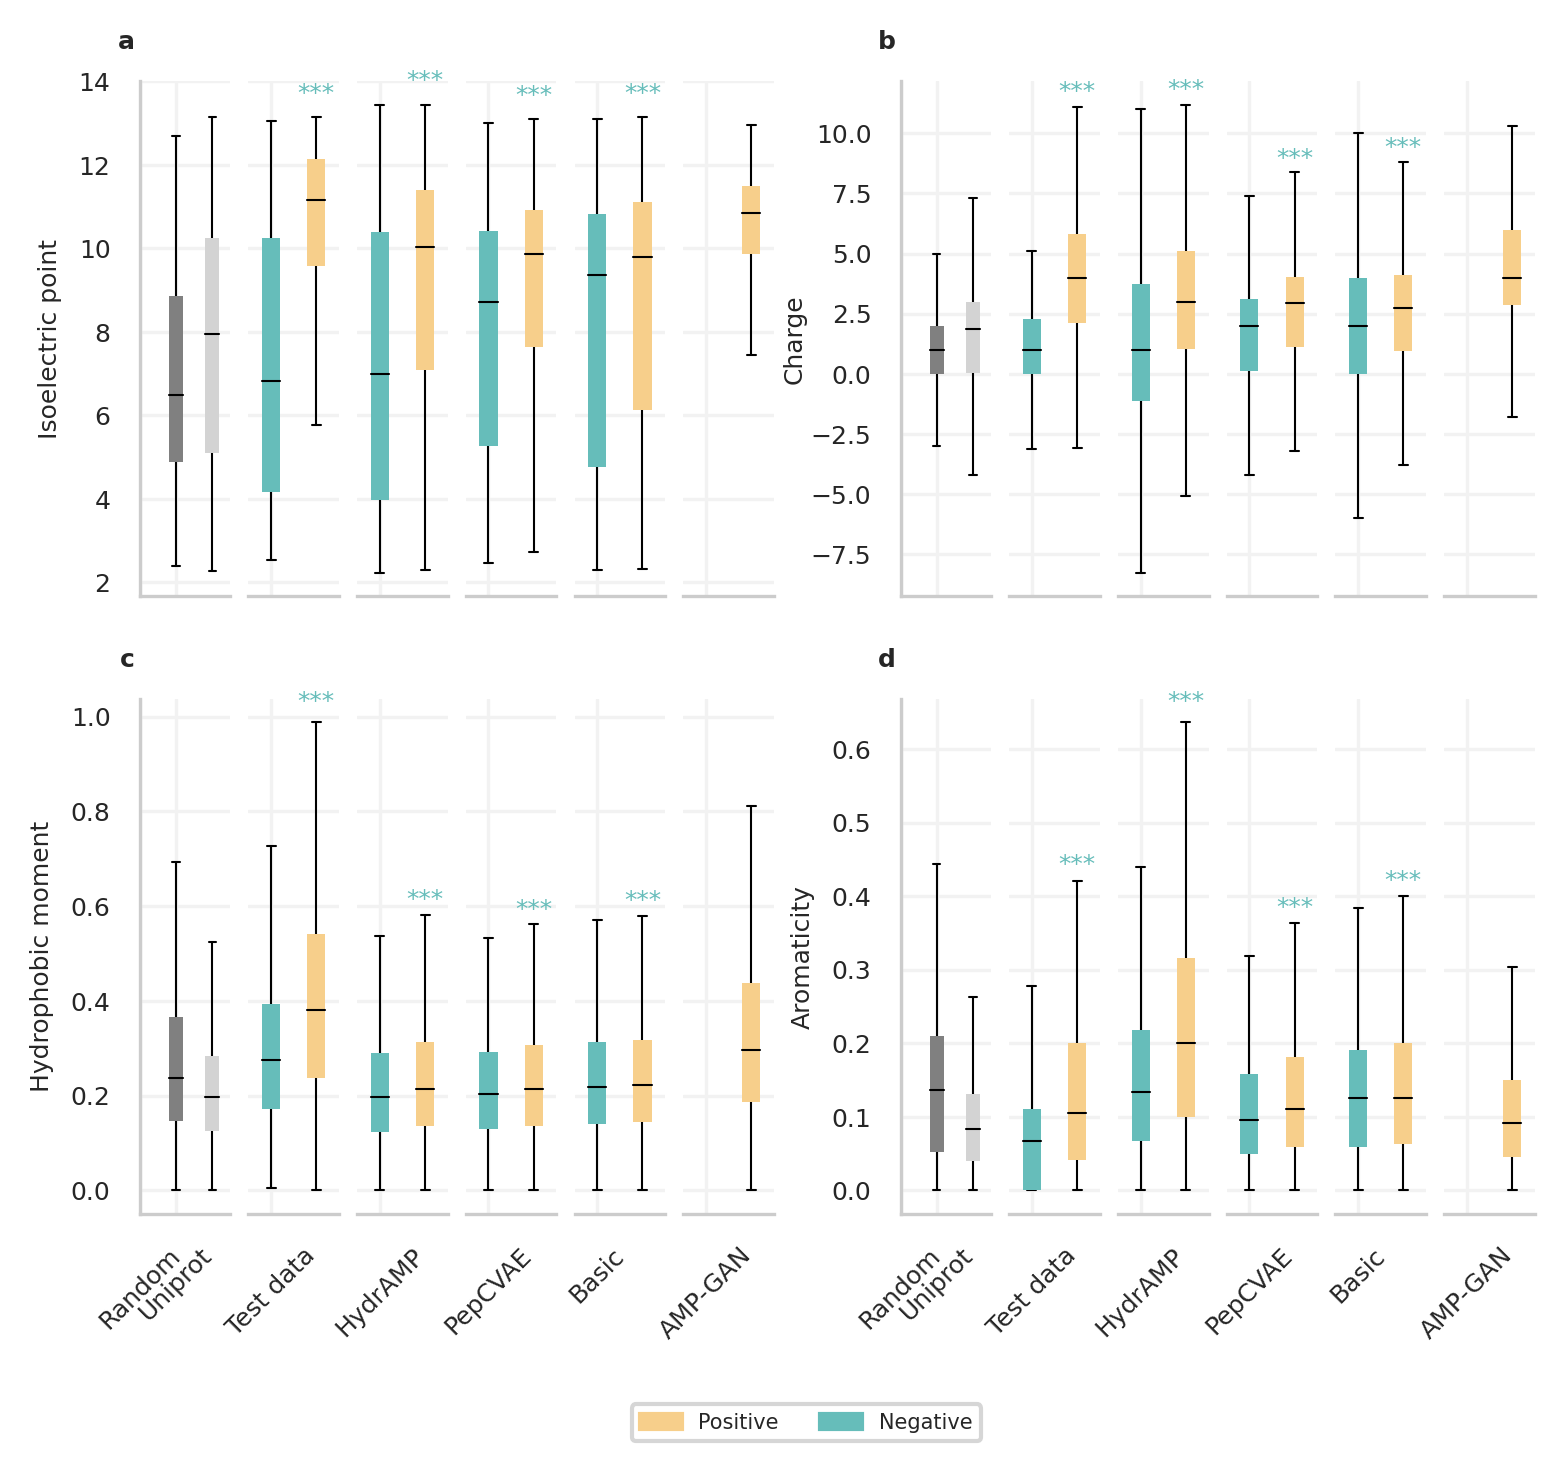

In [61]:
fig, master_axes = plt.subplots(
    ncols=13, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

pvalues_dict = {}

for prop, label, axes, in zip(
    ['pi',  'charge',  'hm', 'aromacity', ],
    ['Isoelectric point', 'Charge',  'Hydrophobic moment', 'Aromaticity',],
    [master_axes[0][:6], master_axes[0][7:], master_axes[1][:6], master_axes[1][7:]] ,
):
    for ind, (ax, dataset) in enumerate(zip(axes, datasets)):
        data = [physchem[physchem['dataset'] == x][prop].tolist() for x in dataset]
        parts = ax.boxplot(
            data,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            flierprops=flierprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            widths=0.4      
        )
        if dataset in [['Random','Uniprot']]:
            for patch, color in zip(parts['boxes'], ['grey','lightgray']):
                patch.set_facecolor(color)
        else:
            for patch, color in zip(parts['boxes'], ['#66BDBA', '#F7CF8B',]):
                patch.set_facecolor(color)
            ax.spines['left'].set_visible(False)
            ax.set_yticklabels([])

        if dataset in [['Random', 'Uniprot'], [None, 'AMP AMP-GAN']]:
            continue
            

        test_results = mannwhitneyu(
                physchem[physchem.dataset == dataset[1]][prop].tolist(),
                physchem[physchem.dataset == dataset[0]][prop], 
                alternative='greater'
        )[1]                    

        pvalues_dict[f'{dataset[1]}_{prop}'] = test_results

        symbol = choose_symbol(test_results)

        ax.text(
            x=2,
            y=1.03 * parts['caps'][3].get_ydata()[1],
            s=symbol,
            color='#66BDBA',
            ha='center'
        )   

    mins = [ax.get_ylim()[0] for ax in axes]
    maxs = [ax.get_ylim()[1] for ax in axes]
    for ax in axes:
        ax.set_ylim(min(mins), max(maxs))  
        
    axes[0].set_xticks(range(2))
    axes[0].set_xticklabels([], rotation=45)
    axes[0].set_ylabel(label)
    
    for i in range(1,6):
        axes[i].set_xticks([1])   
        axes[i].set_xticklabels([], rotation=45)      
    
fig.delaxes(master_axes[0][6])
fig.delaxes(master_axes[1][6])

for i, (label, ax) in enumerate(
    zip(
        ['a', 'b', 'c', 'd'],
        [master_axes[0][0], master_axes[0][7], master_axes[1][0], master_axes[1][7]]
    )
):
    ax.annotate(label, xy=(-0.05, 1.1), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')
    
    for i in range(1,13):
        master_axes[1][i].set_xticks([1])   

    master_axes[1][0].set_xticks(range(2))
    master_axes[1][0].set_xticklabels(['Random','Uniprot'], rotation=45)
    master_axes[1][1].set_xticklabels(['Test data'], rotation=45)    
    master_axes[1][2].set_xticklabels(['HydrAMP'], rotation=45)   
    master_axes[1][3].set_xticklabels(['PepCVAE'], rotation=45)       
    master_axes[1][4].set_xticklabels(['Basic'], rotation=45)  
    master_axes[1][5].set_xticklabels(['AMP-GAN'], rotation=45)      
    
    master_axes[1][7].set_xticks(range(2))
    master_axes[0][7].yaxis.labelpad = 1
    master_axes[1][7].set_xticklabels(['Random','Uniprot'], rotation=45)
    master_axes[1][8].set_xticklabels(['Test data'], rotation=45)
    master_axes[1][9].set_xticklabels(['HydrAMP'], rotation=45)   
    master_axes[1][10].set_xticklabels(['PepCVAE'], rotation=45)       
    master_axes[1][11].set_xticklabels(['Basic'], rotation=45)  
    master_axes[1][12].set_xticklabels(['AMP-GAN'], rotation=45)      
    
plt.legend(
    handles=[
        mpatches.Patch(color='#F7CF8B', label='Positive'),    
        mpatches.Patch(color='#66BDBA', label='Negative'),
    ], 
    bbox_to_anchor = (-5, -0.35),
    ncol=2,
)
    
# fig.tight_layout()
fig.savefig("../../figures/UnconstrainedGeneration_PhysicochemicalProperties.svg")
fig.savefig("../../figures/UnconstrainedGeneration_PhysicochemicalProperties.pdf", bbox_inches="tight")
plt.show()

In [75]:
pvalues_dict = {k.replace('AMP ', ''): v for k, v in pvalues_dict.items()}
charge_pvalues = {k.split('_charge')[0]: v for k, v in pvalues_dict.items() if 'charge' in k}
pi_pvalues = {k.split('_pi')[0]: v for k, v in pvalues_dict.items() if 'pi' in k}
hm_pvalues = {k.split('_hm')[0]: v for k, v in pvalues_dict.items() if 'hm' in k}
aromacity_pvalues = {k.split('_aromacity')[0]: v for k, v in pvalues_dict.items() if 'aromacity' in k}


charge_pvalues = pd.DataFrame.from_dict(charge_pvalues, orient='index')
pi_pvalues = pd.DataFrame.from_dict(pi_pvalues, orient='index')
hm_pvalues = pd.DataFrame.from_dict(hm_pvalues, orient='index')
aromacity_pvalues = pd.DataFrame.from_dict(aromacity_pvalues, orient='index')

pvalues = pd.concat([charge_pvalues, pi_pvalues, hm_pvalues, aromacity_pvalues], axis=1)
pvalues.columns = ['Charge', 'pI', 'Hydrophobic moment', 'Aromacity']
pvalues.to_csv('Supp_SourceData_FigureS1_pvalues.csv')